# 1 — Setup: imports, seeds, GPU suggestion

In [1]:
# 1. Setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import sklearn.manifold as sk_tsne
from sklearn.decomposition import PCA
import random
import os

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TF version:", tf.__version__)

TF version: 2.19.0


# 2 — Load and preprocess MNIST

In [2]:
# 2. Load & preprocess MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Binarize images (sample threshold 0.5) suitable for binary RBM
x_train_bin = (x_train > 0.5).astype('float32')
x_test_bin  = (x_test > 0.5).astype('float32')

# Flatten to 784 dims
x_train_bin = x_train_bin.reshape((-1, 784))
x_test_bin  = x_test_bin.reshape((-1, 784))

print("Train shape:", x_train_bin.shape, "Test shape:", x_test_bin.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (60000, 784) Test shape: (10000, 784)


# 3 — RBM class implementation

In [3]:
# 3. RBM implementation (Contrastive Divergence CD-1)
class RBM:
    def __init__(self, n_visible=784, n_hidden=128, learning_rate=0.01):
        self.n_visible = n_visible
        self.n_hidden  = n_hidden
        self.lr = learning_rate

        # Initialize weights: small random normal
        init_std = 0.01
        self.W = tf.Variable(tf.random.normal([self.n_visible, self.n_hidden], stddev=init_std), dtype=tf.float32)
        self.bv = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)  # visible bias
        self.bh = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)   # hidden bias

    def sample_prob(self, probs):
        """Bernoulli sampling given probabilities."""
        return tf.cast(tf.random.uniform(tf.shape(probs)) < probs, tf.float32)

    def propup(self, v):
        """Compute p(h=1|v) and sample h."""
        pre_sigmoid = tf.linalg.matmul(v, self.W) + self.bh  # shape (batch, n_hidden)
        ph_given_v = tf.sigmoid(pre_sigmoid)
        return ph_given_v

    def propdown(self, h):
        """Compute p(v=1|h) and sample v."""
        pre_sigmoid = tf.linalg.matmul(h, tf.transpose(self.W)) + self.bv  # shape (batch, n_visible)
        pv_given_h = tf.sigmoid(pre_sigmoid)
        return pv_given_h

    def gibbs_hvh(self, v0):
        """One-step Gibbs: v0 -> h0 -> v1 -> h1 (returns probs and samples)."""
        ph0 = self.propup(v0)
        h0  = self.sample_prob(ph0)
        pv1 = self.propdown(h0)
        v1  = self.sample_prob(pv1)
        ph1 = self.propup(v1)
        return ph0, h0, pv1, v1, ph1

    def contrastive_divergence(self, v0):
        """Perform CD-1 update for one minibatch v0."""
        ph0, h0, pv1, v1, ph1 = self.gibbs_hvh(v0)
        # Positive and negative gradients
        pos_grad = tf.linalg.matmul(tf.transpose(v0), ph0)   # (n_visible, n_hidden)
        neg_grad = tf.linalg.matmul(tf.transpose(v1), ph1)   # (n_visible, n_hidden)

        batch_size = tf.cast(tf.shape(v0)[0], tf.float32)
        # Parameter updates (gradient step)
        dW  = (pos_grad - neg_grad) / batch_size
        dbv = tf.reduce_mean(v0 - v1, axis=0)
        dbh = tf.reduce_mean(ph0 - ph1, axis=0)

        # Apply updates (note: using simple SGD)
        self.W.assign_add(self.lr * dW)
        self.bv.assign_add(self.lr * dbv)
        self.bh.assign_add(self.lr * dbh)

        # Reconstruction error (MSE) between v0 and pv1 (use probabilities pv1)
        pv1_prob = pv1  # probabilities returned from propdown
        recon_err = tf.reduce_mean(tf.square(v0 - pv1_prob))
        return recon_err

    def reconstruct(self, v):
        """Return reconstruction probabilities given v (forward pass)."""
        ph = self.propup(v)
        pv = self.propdown(ph)
        return pv

    def get_hidden(self, v):
        """Return hidden probabilities (features)."""
        return self.propup(v)

# 4 — Hyperparameters and initialize RBM

In [4]:
# 4. Hyperparameters & init
n_visible = 784
n_hidden = 128   # or 64 based on assignment choice
learning_rate = 0.01
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=learning_rate)
print(f"RBM initialized: visible={n_visible}, hidden={n_hidden}, lr={learning_rate}")

RBM initialized: visible=784, hidden=128, lr=0.01


# 5 — Training loop with CD-1

In [5]:
# 5. Train RBM using CD-1
epochs = 20
batch_size = 64
n_train = x_train_bin.shape[0]
num_batches = n_train // batch_size

train_errors = []

for epoch in range(1, epochs + 1):
    # shuffle
    idx = np.random.permutation(n_train)
    epoch_err = 0.0
    for b in range(num_batches):
        batch_idx = idx[b*batch_size:(b+1)*batch_size]
        v0 = tf.convert_to_tensor(x_train_bin[batch_idx], dtype=tf.float32)
        err = rbm.contrastive_divergence(v0)
        epoch_err += err.numpy()
    epoch_err /= num_batches
    train_errors.append(epoch_err)
    print(f"Epoch {epoch:02d}/{epochs} - recon_error: {epoch_err:.6f}")

Epoch 01/20 - recon_error: 0.077496
Epoch 02/20 - recon_error: 0.056003
Epoch 03/20 - recon_error: 0.049307
Epoch 04/20 - recon_error: 0.045279
Epoch 05/20 - recon_error: 0.042438
Epoch 06/20 - recon_error: 0.040357
Epoch 07/20 - recon_error: 0.038748
Epoch 08/20 - recon_error: 0.037433
Epoch 09/20 - recon_error: 0.036349
Epoch 10/20 - recon_error: 0.035414
Epoch 11/20 - recon_error: 0.034626
Epoch 12/20 - recon_error: 0.033935
Epoch 13/20 - recon_error: 0.033324
Epoch 14/20 - recon_error: 0.032764
Epoch 15/20 - recon_error: 0.032275
Epoch 16/20 - recon_error: 0.031851
Epoch 17/20 - recon_error: 0.031451
Epoch 18/20 - recon_error: 0.031057
Epoch 19/20 - recon_error: 0.030743
Epoch 20/20 - recon_error: 0.030410


# 6 — Plot reconstruction error vs epochs

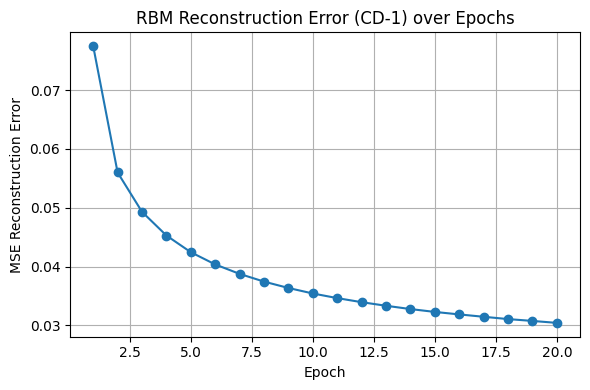

<Figure size 640x480 with 0 Axes>

In [6]:
# 6. Plot reconstruction error
plt.figure(figsize=(6,4))
plt.plot(range(1, epochs+1), train_errors, marker='o')
plt.title('RBM Reconstruction Error (CD-1) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Reconstruction Error')
plt.grid(True)
plt.tight_layout()
plt.show()
# optional save
plt.savefig('rbm_recon_error.png', dpi=150, bbox_inches='tight')

# 7 — Extract hidden representations for MNIST

In [7]:
# 7. Get hidden representations
# Use probabilities (not samples) as features
batch_size_feat = 256
def get_hidden_features(data):
    features = []
    n = data.shape[0]
    for i in range(0, n, batch_size_feat):
        batch = tf.convert_to_tensor(data[i:i+batch_size_feat], dtype=tf.float32)
        ph = rbm.get_hidden(batch).numpy()
        features.append(ph)
    return np.vstack(features)

hidden_train = get_hidden_features(x_train_bin)
hidden_test  = get_hidden_features(x_test_bin)

print("Hidden train shape:", hidden_train.shape)
print("Hidden test shape:", hidden_test.shape)

Hidden train shape: (60000, 128)
Hidden test shape: (10000, 128)


# 8 — Visualize hidden space with t-SNE (or PCA)

Running PCA (for quick 2D)...


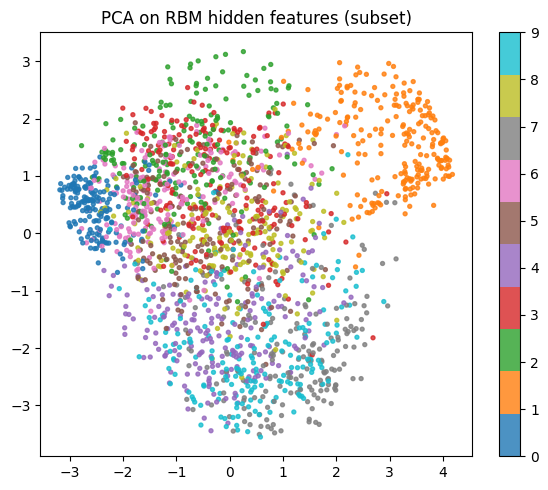

Running t-SNE (this may take a while for 2000 samples)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


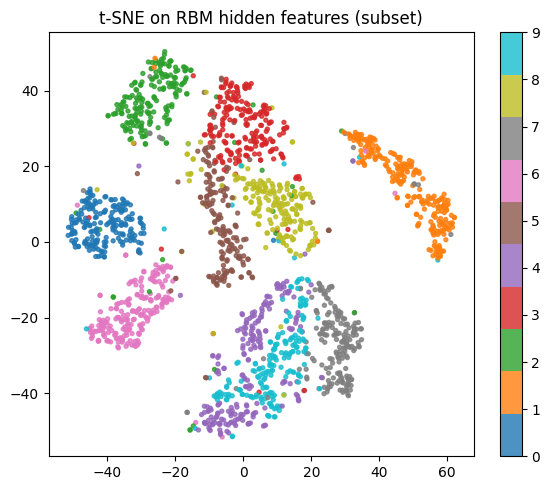

In [8]:
# 8. Visualize with t-SNE (subsample for speed)
n_vis = 2000
idx_vis = np.random.choice(hidden_test.shape[0], n_vis, replace=False)
X_vis = hidden_test[idx_vis]
y_vis = y_test[idx_vis]

print("Running PCA (for quick 2D)...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_vis, cmap='tab10', s=8, alpha=0.8)
plt.title('PCA on RBM hidden features (subset)')
plt.colorbar(scatter, ticks=range(10))
plt.tight_layout()
plt.show()

# Now t-SNE (slower)
print("Running t-SNE (this may take a while for 2000 samples)...")
tsne = sk_tsne.TSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_vis)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_vis, cmap='tab10', s=8, alpha=0.8)
plt.title('t-SNE on RBM hidden features (subset)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 9 — Reconstruct images and visualize real vs reconstructed

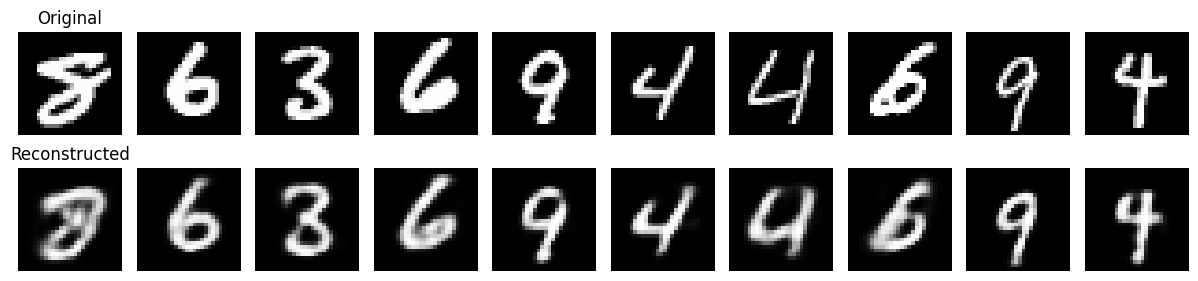

In [9]:
# 9. Reconstruct some test images and show results
num_examples = 10
idx = np.random.choice(x_test_bin.shape[0], num_examples, replace=False)
v = tf.convert_to_tensor(x_test_bin[idx], dtype=tf.float32)
pv = rbm.reconstruct(v).numpy()  # probabilities

plt.figure(figsize=(12,3))
for i in range(num_examples):
    ax = plt.subplot(2, num_examples, i+1)
    plt.imshow(x_test[idx[i]].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    ax = plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(pv[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Reconstructed')
plt.tight_layout()
plt.show()

# 10 — Save learned hidden features to disk

In [10]:
# 10. Save hidden features
np.save('hidden_train.npy', hidden_train)
np.save('hidden_test.npy', hidden_test)
print("Hidden features saved: hidden_train.npy, hidden_test.npy")

Hidden features saved: hidden_train.npy, hidden_test.npy
